# BSSD - Blind Source Separation Denoising

**main function: denoise(** *ROIs_means_corrected, time, inactive_msk, t_sig_onset, method='ICA', n_comp=2, wavelet='Haar', autoselect='auto'* **)**

Return ROIs means filtered by Blind Source Separations (BSS) methods, estimated sources (components) of the observations, index of the selected source and estimated Signal-to-Noise Ratio in each ROI.

Estimates noise power from inactive interval defined by *inactive_mask*. Then, applies a BSS method defined by *method* (with the wavelet filtering defined by *wavelet* if 'wPCA' or 'wICA' are chosen) and selects one or more components as representing the sources of the signal(s). Source selection can be manual or automatic. If auto, components are plotted and user must type source(s) number(s). If manual, source selection is done based on portions of the components that are higher than 2 times the noise standard deviation (only 1 source is selected when using *autoselect*='auto'). After that, inverse transformation is executed to rebuild the observations using just the selected source(s). Finally, signal power is calculated, as well as Signal-to-Noise Ratio (SNR) in each observation.

**Parameters:**  
- **ROIs_means_corrected: array**
    - (F x R) array, where F are frames and R are ROI numbers. Also called observations.
- **time: array**
    - (F,) array, where F are time points.
- **inactive_msk: boolean array**
    - (F) boolean array, where F are frames.
- **t_sig_onset: float**
    - time instant (in seconds) when signal is supposed to start.
- **method: string, optional**
    - *PCA*, *ICA*, *wPCA* or *wICA*.
- **n_comp: int, optional**
    - Number of components to allocate estimated sources (same as *n_components* input in [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.fastica.html#sklearn.decomposition.fastica) and [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)) . n_comp=2 means to separate into 2 components for later source selection (only 1 source is selected if autoselect='auto').
- **wavelet: string, optional**
    - string representing the wavelet to be used (same as in [Pywavelets](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)).
- **autoselect: string, optional**
    - string that determines whether source selection will be done manually (autoselect='manual') or automatically (autoselect='auto').
 
**Returns:** 
- **ROIs_means_filtered: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **components: array**
    - (F x n_comp) array, where F are frames and n_comp is the number of components.
- **selected_source_idx: int**
    - index of the selected source.
- **SNR_dB: array**
    - (R,) array, where R are ROI numbers.

In [1]:
testing = (__name__ == "__main__")
if testing:
#     %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os
    bssdpath = os.path.abspath('')
    if bssdpath not in sys.path:
        sys.path.append(bssdpath)
    items = os.listdir(bssdpath)
    if 'MESS.py' not in items:
        ! jupyter nbconvert --to 'python' MESS.ipynb
    if 'Remove_Photobleaching.py' not in items:
        ! jupyter nbconvert --to 'python' Remove_Photobleaching.ipynb
    import MESS as mes
    import Remove_Photobleaching as rpb

[NbConvertApp] Converting notebook Remove_Photobleaching.ipynb to python
[NbConvertApp] Writing 14436 bytes to Remove_Photobleaching.py


## Mandatory Parameters:

In [2]:
if testing:
    from skimage import io
    fpath = 'Data\\Cell1\\videos_AP'
    fr = 55.78
    
    fname = 'vid1.tif'
    fullpath = fpath + '\\' + fname
    video = io.imread(fullpath)
    
    mname = 'cellmask.tif'
    fullpath = fpath + '\\' + mname
    mask = io.imread(fullpath)
    
    transitory=True

## Optional Parameters:

In [3]:
if testing:
    t_sig_onset=0.5
    t_sig_end=1
    autoselect='manual'

# Apply MESS and Remove_Photobleaching:

In [4]:
if testing:
    ROIs_masks, label_ROIs, ROIs_means, time  = mes.segment(mask,video, fr)
    ROIs_means_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)

# BSSD functions:

In [5]:
def get_noise_power(ROIs_means_corrected,time,inactive_msk=None):
    import numpy as np
    nregions = ROIs_means_corrected.shape[1]
    if np.any(inactive_msk)==None:
        inactive_msk = np.ones_like(time,dtype=bool)
#     for m,t,cnt,idx in zip(ROIs_means_corrected,time,range(len(time)),inactive_msk):
    noise = np.zeros((nregions,))
    for j in range(nregions):
        #Get NOISE POWER
        noise[j] = np.sum(np.square(abs(ROIs_means_corrected[inactive_msk,j])),axis=0)/(ROIs_means_corrected[inactive_msk,:].shape[0])
    return(noise)

In [6]:
def guess_t_sig_active_time(sources, t_sig_onset_idx):
    '''Returns indices of time vector later then t_sig_onset and when they are bigger than channel background noise'''
    import numpy as np
    noise_threshold = np.mean(sources[:t_sig_onset_idx,:],axis=0) + 2*np.std(sources[:t_sig_onset_idx,:],axis=0)
    t_sig_active = np.empty_like(sources,dtype=bool)
    for i in range(len(noise_threshold)):
        t_sig_active[:,i] = np.where(sources[:,i]>noise_threshold[i],True,False)
        t_sig_active[:t_sig_onset_idx,i] = False
    return(noise_threshold, t_sig_active)

In [7]:
def get_signal_power(ROIs_means_corrected,time,inactive_msk=None):
    import numpy as np
    nregions = ROIs_means_corrected.shape[1]
    if np.any(inactive_msk)==None:
        inactive_msk = np.ones_like(time,dtype=bool)
    active_mask = np.invert(inactive_msk)
    #Get SIGNAL POWER
    signal_power = np.sum(np.square(abs(ROIs_means_corrected[active_mask])),axis=0)/(len(active_mask))
    return(signal_power)

In [8]:
def manual_select():
    import numpy as np
    nb = input('Enter one or more sources number (separate numbers by "," if number of sources > 1): ')
    selected_source_idx = []
    if nb.find(',')==-1: #Single source selected
        try:
            number = int(nb)
            selected_source_idx.append(number)
        except ValueError:
            print("Invalid number")
    else:
        nb = nb.replace(" ","")
        commas_idx = []
        import re
        for m in re.finditer(',', nb):
            commas_idx.append(m.start())
        try:
            number = int(nb[:commas_idx[0]])
            selected_source_idx.append(number)
            for i in range(len(commas_idx)):
                if i==len(commas_idx)-1:
                    number = int(nb[commas_idx[i]+1:])
                else:
                    number = int(nb[commas_idx[i]+1:commas_idx[i+1]])
                selected_source_idx.append(number)
        except ValueError:
            print("Invalid number list")
    return(np.array(selected_source_idx))
            

In [9]:
def wavelet_denoise(S, time, wave='Haar'):
    import numpy as np
    import pywt
    from statsmodels.robust.scale import mad
    w = pywt.Wavelet(wave)
    shape = S.shape
    n = shape[0]
    #Denoise just one component
    if len(shape)==1:
        if (n%2!=0):
            Y = np.zeros((n+1,))
        else:
            Y = np.zeros_like(S)
        max_level = pywt.dwt_max_level(n, w)
        coeff = pywt.wavedec(S, w, mode='periodization',level=max_level)

        sigma = mad(coeff[-1])
        K = np.sqrt(2*np.log(time.shape[0]))*sigma

        coeff_T = []
        for j in range(len(coeff)):
            c = pywt.threshold(coeff[j], K, 'hard')
            coeff_T.append(c)
        Y = pywt.waverec(coeff_T, w ,mode='periodization')
        if (n%2!=0):
            Y = Y[:len(Y)-1]
    return(Y)

In [10]:
def auto_select_signal(sources, time, t_sig_onset_idx):
    import numpy as np
    noise_threshold = 2*np.std(sources[:t_sig_onset_idx,:],axis=0)
    t_sig_active = np.where(abs(sources-np.mean(sources[:t_sig_onset_idx,:],axis=0))>noise_threshold,True,False)
    t_sig_active[:t_sig_onset_idx] = False
    sources_abovenoise_power = np.empty((sources.shape[1],))
    for i in range(sources.shape[1]):
        active_idxs = get_longest_ones_seq_idx(t_sig_active[:,i])
        if np.any(active_idxs)==None:
            sources_abovenoise_power[i] = 0  
        else:
            sources_abovenoise_power[i] = np.sum(np.square(sources[active_idxs,i]))
    sources_idx_sorted = np.argsort(sources_abovenoise_power)
    sources_idx_sorted_inverse = sources_idx_sorted[::-1] #sorts from max to min
    return(sources_idx_sorted_inverse)

In [11]:
def get_longest_ones_seq_idx(t_sig_active):
    import numpy as np
    ones_pos = np.nonzero(t_sig_active)[0]
    if ones_pos.size==0:
        return(None)
    else:
        d_ones_pos = np.diff(ones_pos)
        d_ones_pos = np.insert(d_ones_pos,len(d_ones_pos),0)
        seq=0
        maxseq=0
        for i in range(len(ones_pos)):
            if d_ones_pos[i]==1:
                seq+=1
            else:
                if ((seq+1)>maxseq):
                    maxseq = seq+1
                    pos = ones_pos[i] - seq
                    pos_end = ones_pos[i]+1
                seq = 0
        longest_idxs = np.arange(pos,pos_end)
    return(longest_idxs)

# Main Function:

In [12]:
def denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method='ICA',n_comp=2,wavelet='Haar',autoselect='auto'):
    import numpy as np
    import matplotlib.pyplot as plt
    noise_power = get_noise_power(ROIs_means_corrected,time,inactive_msk=inactive_msk)
    
    if (method=='ICA') | (method=='wICA'):
        from sklearn.decomposition import FastICA
        bss = FastICA(n_components=n_comp,max_iter=2000,tol=0.01)
    if (method=='PCA') | (method=='wPCA'):
        from sklearn.decomposition import PCA
        bss = PCA(n_components=n_comp)
    t_sig_onset_idx = np.argmin(abs(time-t_sig_onset))
    
    components = bss.fit_transform(ROIs_means_corrected)  # Estimate sources
    components_filt = np.zeros_like(components)
    if autoselect=='auto':
        sources_idx_sorted_inverse = auto_select_signal(components, time, t_sig_onset_idx)
        selected_source_idx = sources_idx_sorted_inverse[0]
    else:
        plt.figure(figsize=[15,n_comp*2])
        plt.title('Type source numbers that countain signal')
        for i in range(n_comp):
            plt.subplot(n_comp,1,i+1)
            plt.plot(time,components[:,i])
            plt.axvline(t_sig_onset,color='k',linestyle='--',alpha=0.3)
            ymax = np.mean(components[inactive_msk,i]) + 2*np.std(components[inactive_msk,i])
            ymin = np.mean(components[inactive_msk,i]) - 2*np.std(components[inactive_msk,i])
            span = plt.axhspan(ymin=ymin,ymax=ymax,alpha=0.1,label='Noise CI95')
            s = 'Source #'+str(i)
            plt.ylabel(s,fontsize='large')
            ymin = 1.8*np.amin(components[:,i])
            ymax = 1.8*np.amax(components[:,i])
            plt.ylim(ymin, ymax)
            plt.legend(handles=[span],loc='upper right')
        plt.show()
        selected_source_idx = manual_select()
        plt.close()
    components_filt[:,selected_source_idx] = components[:,selected_source_idx]
    
    if (method=='wPCA') | (method=='wICA'):
        for i in range(np.size(selected_source_idx)):
            components_filt[:,i] = wavelet_denoise(components_filt[:,i],time,wave=wavelet)
    ROIs_means_filtered = bss.inverse_transform(components_filt)
    ROIs_means_filtered = ROIs_means_filtered - np.median(ROIs_means_filtered[inactive_msk,:],axis=0)
    
    signal_power = get_signal_power(ROIs_means_filtered,time,inactive_msk)
    
    SNR = signal_power/noise_power
    SNR_dB = np.zeros_like(SNR)
    SNR_dB[SNR>0] = 10*np.log10(SNR[SNR>0])
    
    return(ROIs_means_filtered,components,selected_source_idx,SNR_dB)

# Test

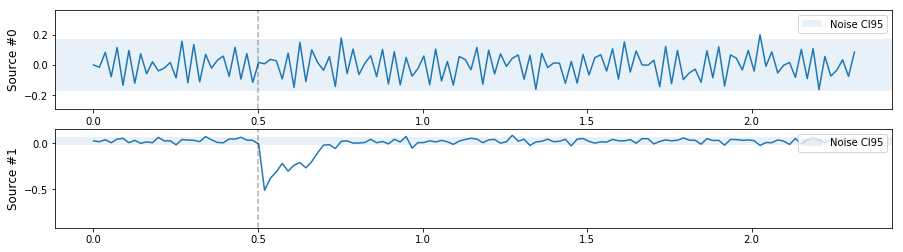

Enter one or more sources number (separate numbers by "," if number of sources > 1): 1


In [13]:
if testing:
    ROIs_means_filtered,components,selected_source_idx,SNR_dB = denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method='ICA',n_comp=2,wavelet='dmey',autoselect=autoselect)

# Time of main function execution:

In [14]:
if testing:
    %timeit ROIs_means_filtered,components,selected_source_idx,SNR_dB = denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method='ICA',n_comp=2,wavelet='dmey',autoselect='auto')

3.19 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Plot results

In [15]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)

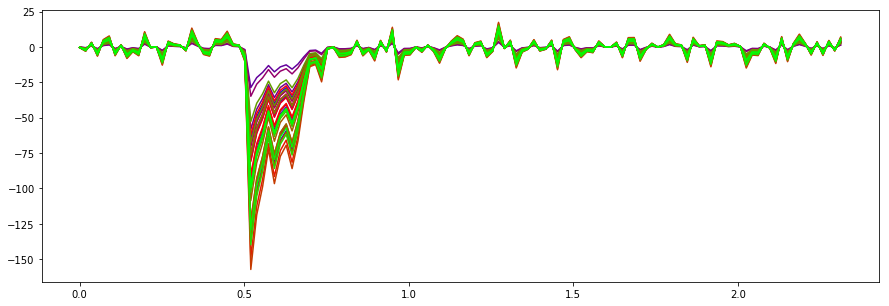

In [16]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_filtered[:,i],color=newcolors[i+1])

In [17]:
if testing:
    print('Signal-to-Noise Ratio:\n',SNR_dB,'dB')

Signal-to-Noise Ratio:
 [ -1.71751169  -8.45145055  -7.41894979 -10.32763207  -4.20687318
  -8.09207804 -15.99529627  -8.8483943   -5.75132194 -12.13894118
  -8.83584665  -3.54955243  -6.09236393  -1.51859556  -6.35990444
  -8.09478069  -5.51372132  -1.30481421  -2.88779721  -0.08402128
  -0.1827062   -2.64399838  -1.74097304  -5.49143095  -6.95869634
  -8.45373242  -4.08979881  -1.67440625  -0.17170625  -2.41372435
  -0.49207979  -4.66340226] dB
